In [1]:
import sys
sys.path.append("../")  

from Segmentation_methods.Dataset.Custom import Custom
from Segmentation_methods.Dataset.Custom import Normalize_data
from Segmentation_methods.utils import show_sample
from Segmentation_methods.utils import inference

import os
import pickle
from sklearn.model_selection import train_test_split
from Segmentation_methods.train import train_model, validate_model
from Segmentation_methods.Modeles.Model import SegmentationModelBuilder
import albumentations as A
from albumentations.pytorch import ToTensorV2


import torch
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.utils.data import ConcatDataset


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/ana

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/ana

AttributeError: _ARRAY_API not found

/users/Etu3/21402333/.local/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# 1) Split, Visualize and prepare data for training 

In [3]:
train_transform = A.Compose(
    [
    A.Resize(256, 256),
    A.Rotate(limit=35, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.GaussianBlur(blur_limit=(3, 7), p=0.05),
    # A.GaussNoise(var_limit=(0, 1), p=0.3),
    A.Normalize(mean=[0.1293, 0.1293, 0.1293], std=[0.2397, 0.2397, 0.2396]),
    ToTensorV2(),
    ],
    additional_targets={"mask_rgb": "mask"}
)

val_transform = A.Compose(
        [   
        A.Resize(256, 256),
        A.Normalize(mean=[0.1293, 0.1293, 0.1293], std=[0.2397, 0.2397, 0.2396]),
        ToTensorV2(),
        ],
        additional_targets={"mask_rgb": "mask"}
    )


images_train = os.path.join("Dataset", "Splits", "X_train.pkl")
masks_train = os.path.join("Dataset", "Splits", "Y_train.pkl")
Train_dataset = Custom(image_pkl_path=images_train, mask_pkl_path=masks_train, transform = val_transform)

images_test = os.path.join("Dataset", "Splits", "X_test.pkl")
masks_test = os.path.join("Dataset", "Splits", "Y_test.pkl")
Test_dataset = Custom(image_pkl_path=images_test, mask_pkl_path=masks_test, transform=val_transform)

# Dataloaders
train_loader = DataLoader(Train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(Test_dataset, batch_size=32, shuffle=False)

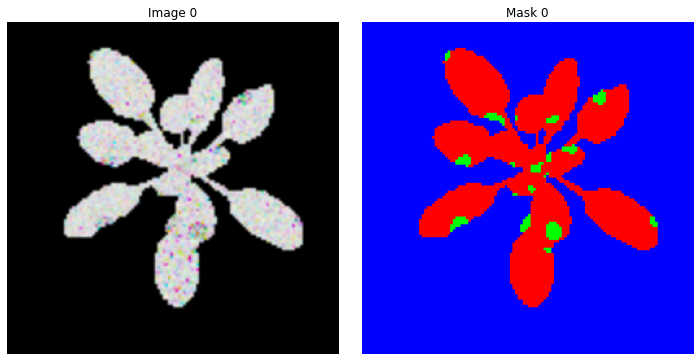

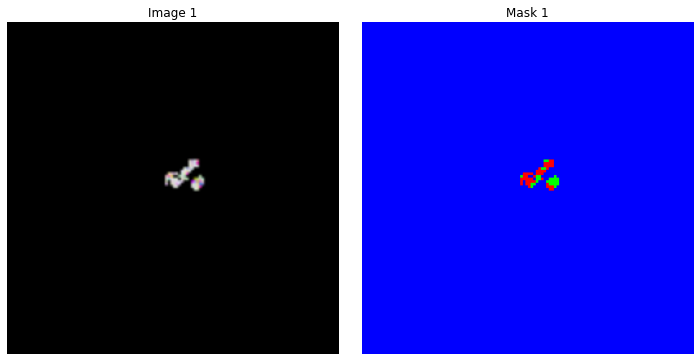

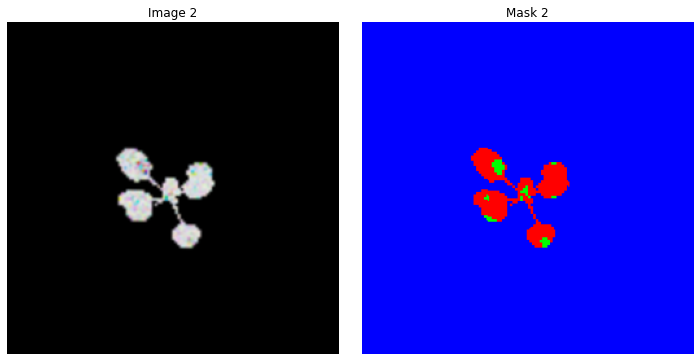

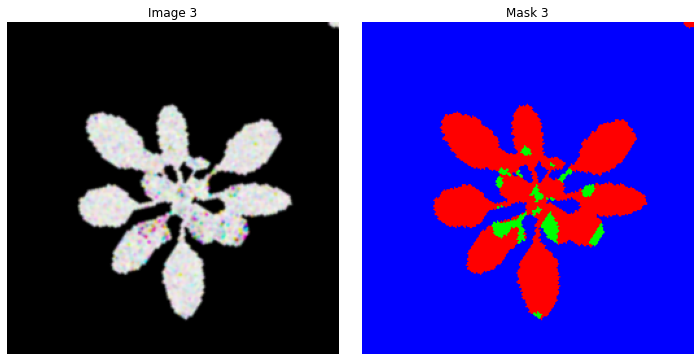

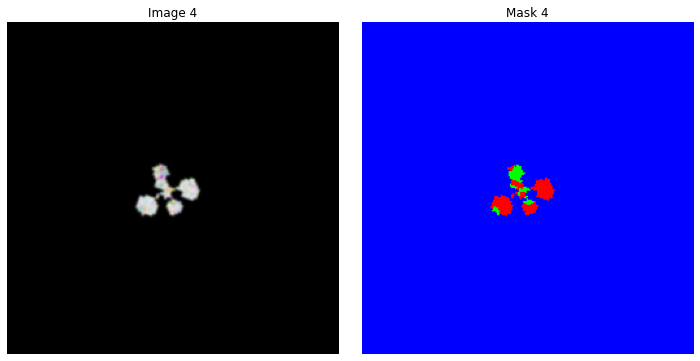

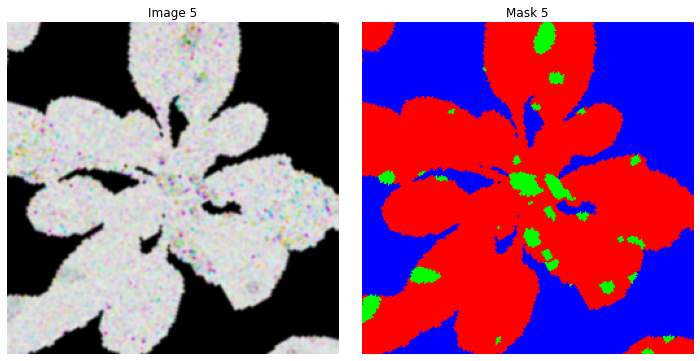

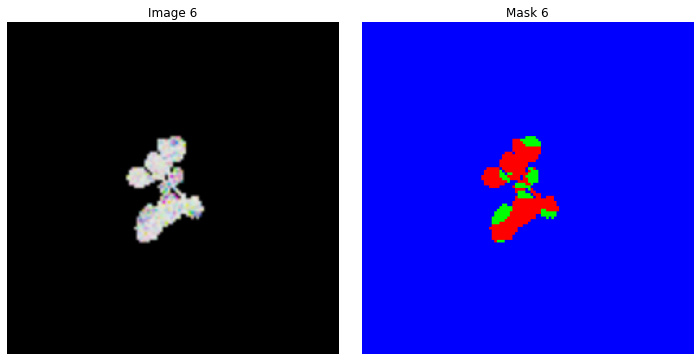

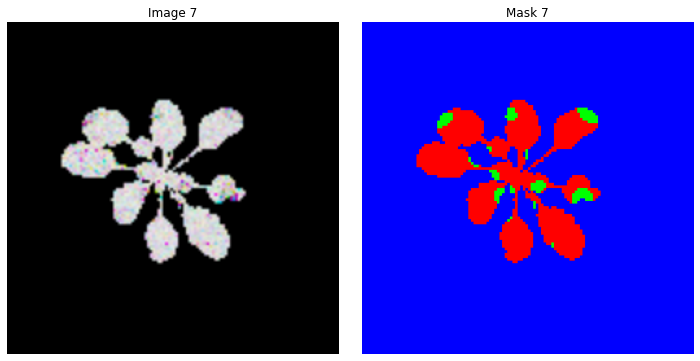

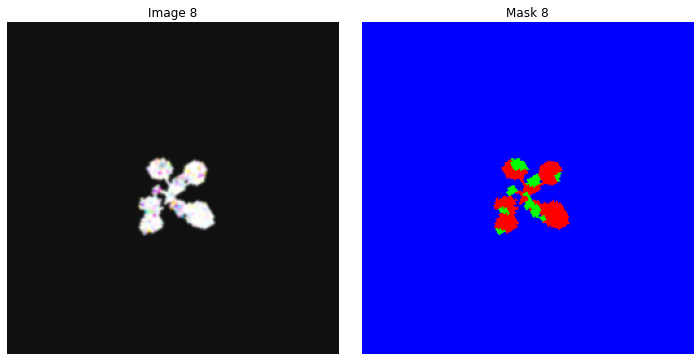

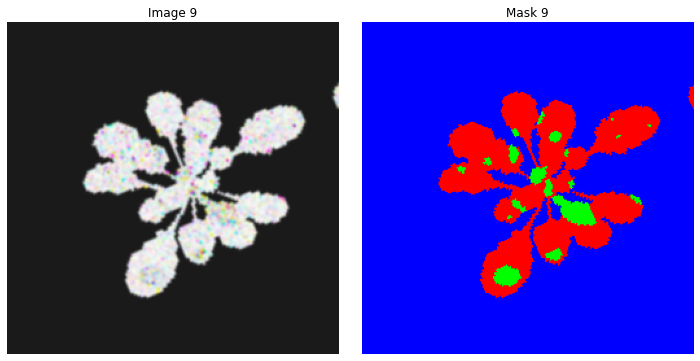

In [13]:
for i in range(10):
    image, mask_rgb, _ = Train_dataset[i]
    show_sample(image, mask_rgb, index=i)
    
# Notice the difference in the scale in the images

# 2) Training phase

In [7]:
backbone_name="resnet152"
device = torch.device("cuda:2")
arch="deeplabv3"
save_path = f"{arch}_{backbone_name}_best_model.pth"

In [8]:
builder = SegmentationModelBuilder(backbone_name, arch, num_classes=3, encoder_weights="imagenet")
model = builder.build()
model = model.to(device)

In [28]:
print(model)

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_


Epoch 1/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.126071
Val Loss: 0.062492 | Mean Jaccard: 0.665043 | Mean Dice: 0.727741 | Mean Recall: 0.709201 | Mean Precision: 0.811777 | Mean ConfIndex: -0.895831


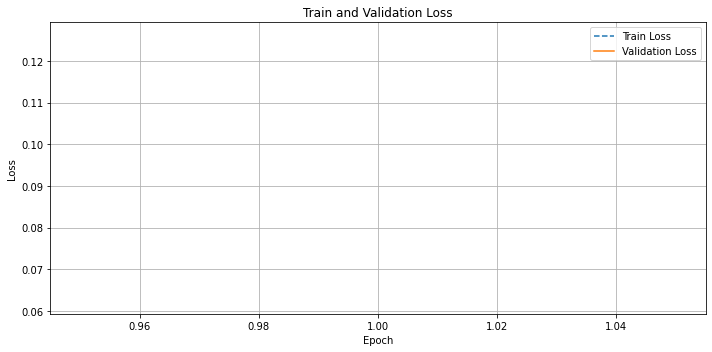


Epoch 2/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.059136
Val Loss: 0.052521 | Mean Jaccard: 0.723318 | Mean Dice: 0.800764 | Mean Recall: 0.783797 | Mean Precision: 0.822079 | Mean ConfIndex: 0.220727


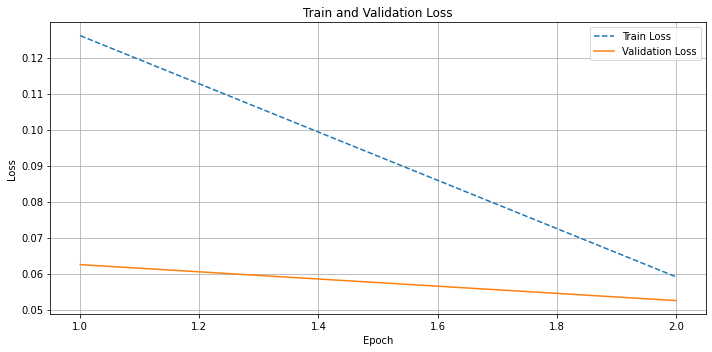


Epoch 3/20


Training: 100%|███████████████████████████████| 137/137 [01:10<00:00,  1.95it/s]


Train Loss: 0.048763
Val Loss: 0.063619 | Mean Jaccard: 0.695001 | Mean Dice: 0.776475 | Mean Recall: 0.810401 | Mean Precision: 0.764274 | Mean ConfIndex: 0.052357


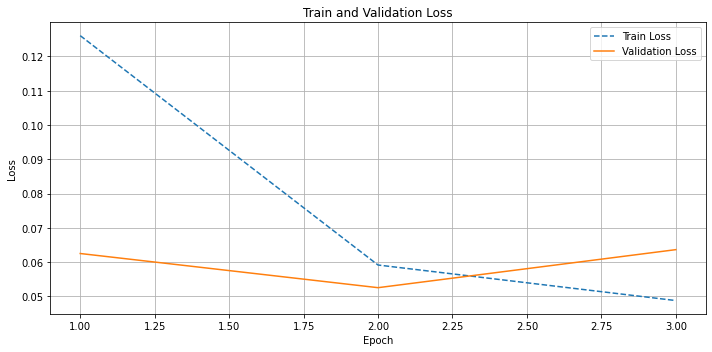


Epoch 4/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.96it/s]


Train Loss: 0.042607
Val Loss: 0.054432 | Mean Jaccard: 0.646287 | Mean Dice: 0.686648 | Mean Recall: 0.680839 | Mean Precision: 0.935641 | Mean ConfIndex: -4.058583


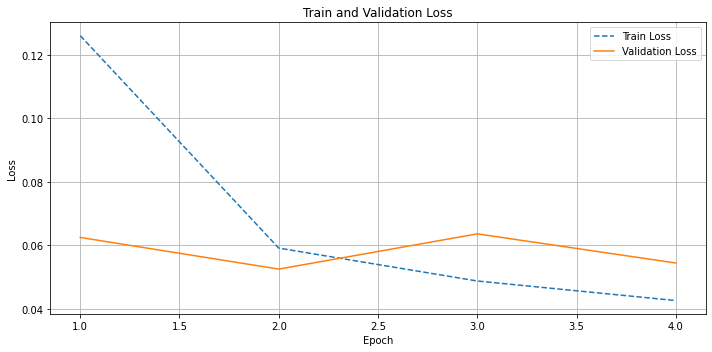


Epoch 5/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.039802
Val Loss: 0.037056 | Mean Jaccard: 0.795683 | Mean Dice: 0.868000 | Mean Recall: 0.856717 | Mean Precision: 0.880783 | Mean ConfIndex: 0.615162


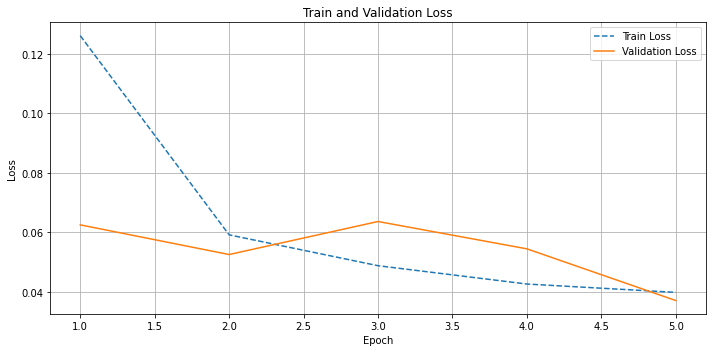


Epoch 6/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.037346
Val Loss: 0.037071 | Mean Jaccard: 0.755389 | Mean Dice: 0.828705 | Mean Recall: 0.781874 | Mean Precision: 0.941702 | Mean ConfIndex: 0.392178


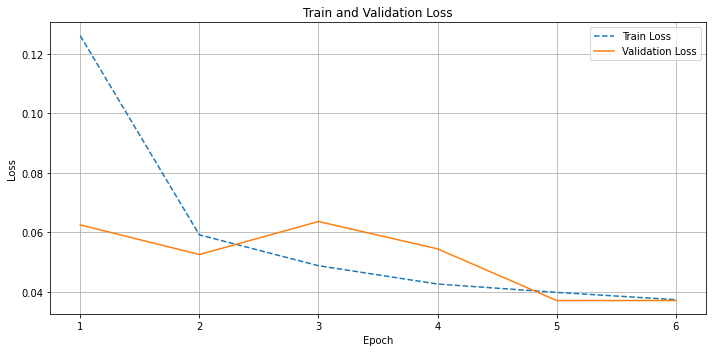


Epoch 7/20


Training: 100%|███████████████████████████████| 137/137 [01:10<00:00,  1.94it/s]


Train Loss: 0.035916
Val Loss: 0.057142 | Mean Jaccard: 0.717328 | Mean Dice: 0.799575 | Mean Recall: 0.865350 | Mean Precision: 0.776756 | Mean ConfIndex: 0.246884


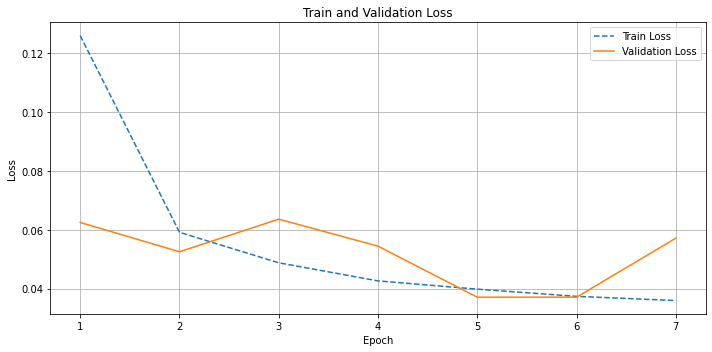


Epoch 8/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.034740
Val Loss: 0.031337 | Mean Jaccard: 0.813286 | Mean Dice: 0.881923 | Mean Recall: 0.854185 | Mean Precision: 0.919728 | Mean ConfIndex: 0.670885


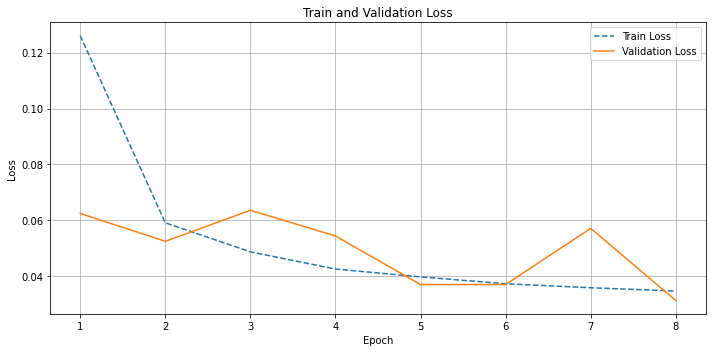


Epoch 9/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.033733
Val Loss: 0.032207 | Mean Jaccard: 0.792666 | Mean Dice: 0.863849 | Mean Recall: 0.823713 | Mean Precision: 0.934301 | Mean ConfIndex: 0.589590


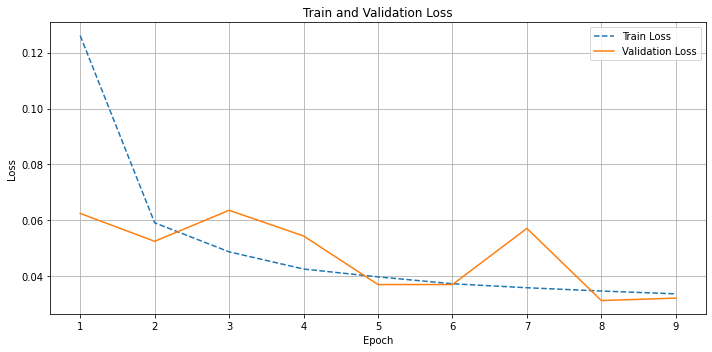


Epoch 10/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.032885
Val Loss: 0.041624 | Mean Jaccard: 0.696066 | Mean Dice: 0.758414 | Mean Recall: 0.721364 | Mean Precision: 0.955714 | Mean ConfIndex: -0.388273


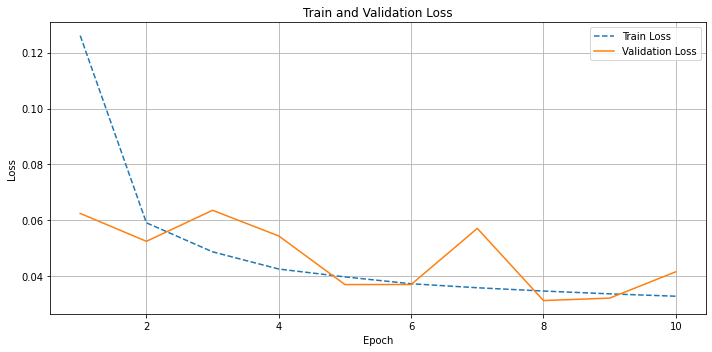


Epoch 11/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.032130
Val Loss: 0.030189 | Mean Jaccard: 0.807834 | Mean Dice: 0.876887 | Mean Recall: 0.839114 | Mean Precision: 0.937743 | Mean ConfIndex: 0.647976


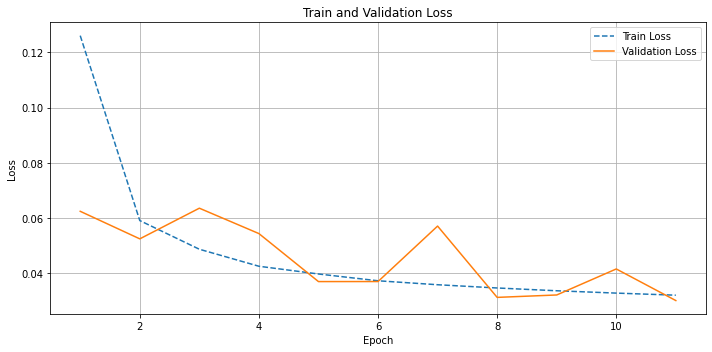


Epoch 12/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.031853
Val Loss: 0.032390 | Mean Jaccard: 0.790386 | Mean Dice: 0.861670 | Mean Recall: 0.819552 | Mean Precision: 0.938744 | Mean ConfIndex: 0.578930


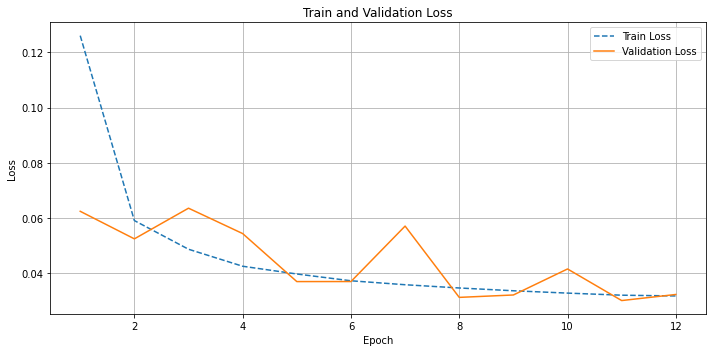


Epoch 13/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.031099
Val Loss: 0.028213 | Mean Jaccard: 0.826218 | Mean Dice: 0.891975 | Mean Recall: 0.865483 | Mean Precision: 0.928430 | Mean ConfIndex: 0.708814


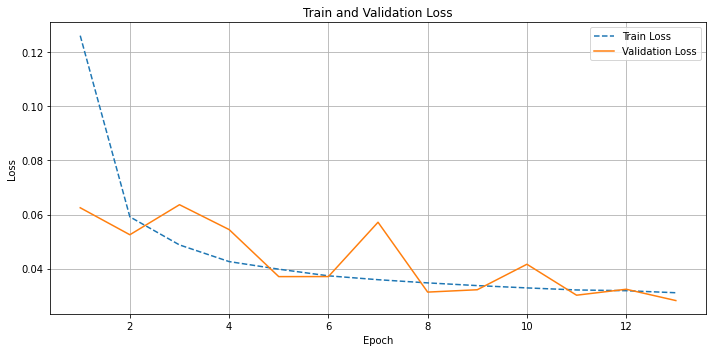


Epoch 14/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.030794
Val Loss: 0.033901 | Mean Jaccard: 0.761725 | Mean Dice: 0.833530 | Mean Recall: 0.787440 | Mean Precision: 0.949096 | Mean ConfIndex: 0.414922


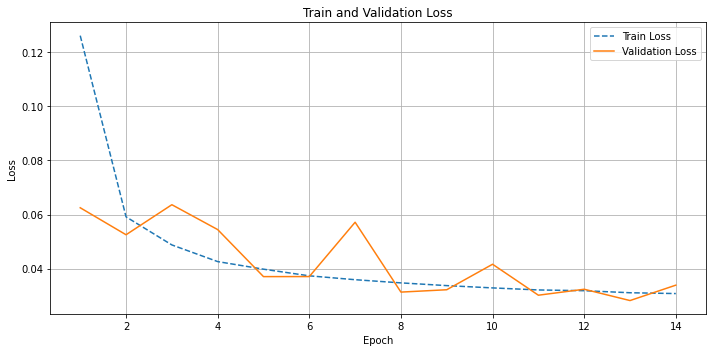


Epoch 15/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.030458
Val Loss: 0.031007 | Mean Jaccard: 0.783366 | Mean Dice: 0.854525 | Mean Recall: 0.810835 | Mean Precision: 0.945755 | Mean ConfIndex: 0.538770


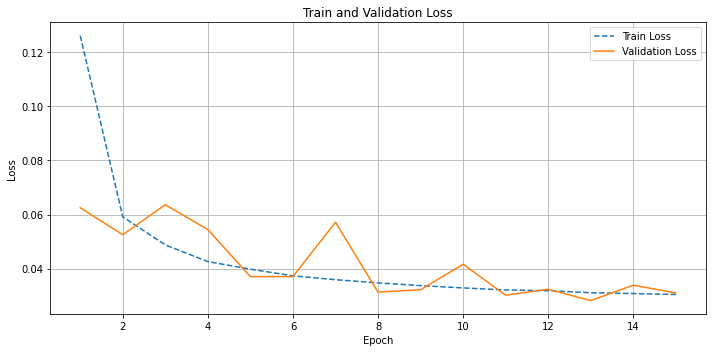


Epoch 16/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.029906
Val Loss: 0.027489 | Mean Jaccard: 0.833130 | Mean Dice: 0.897462 | Mean Recall: 0.874292 | Mean Precision: 0.926564 | Mean ConfIndex: 0.729358


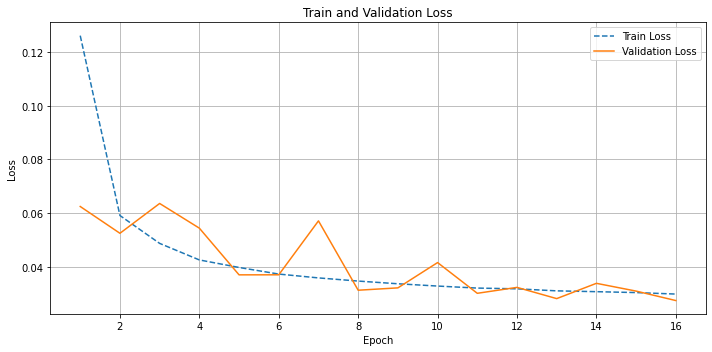


Epoch 17/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.029862
Val Loss: 0.028271 | Mean Jaccard: 0.824307 | Mean Dice: 0.890384 | Mean Recall: 0.864381 | Mean Precision: 0.925750 | Mean ConfIndex: 0.702669


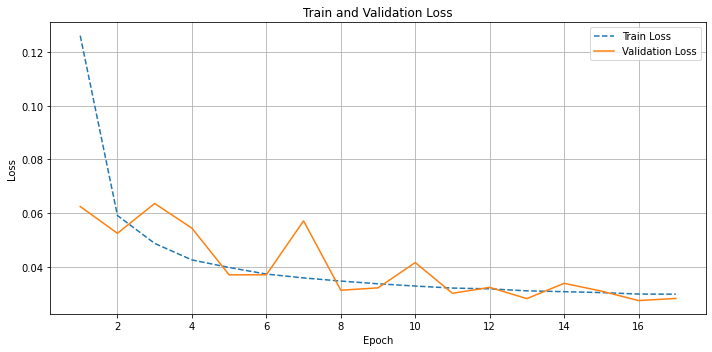


Epoch 18/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.029295
Val Loss: 0.027998 | Mean Jaccard: 0.813893 | Mean Dice: 0.881553 | Mean Recall: 0.842697 | Mean Precision: 0.947033 | Mean ConfIndex: 0.666307


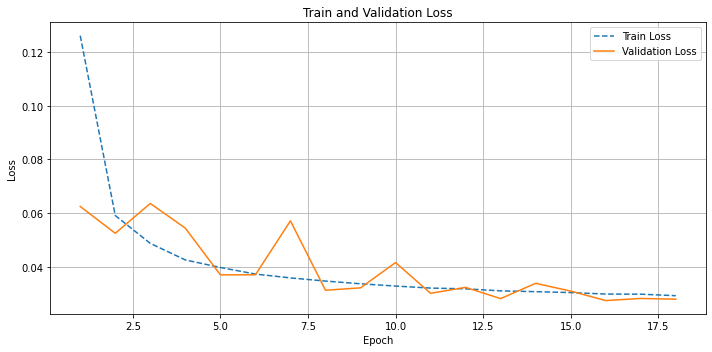


Epoch 19/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.96it/s]


Train Loss: 0.028986
Val Loss: 0.026579 | Mean Jaccard: 0.837928 | Mean Dice: 0.901095 | Mean Recall: 0.885874 | Mean Precision: 0.919129 | Mean ConfIndex: 0.742161


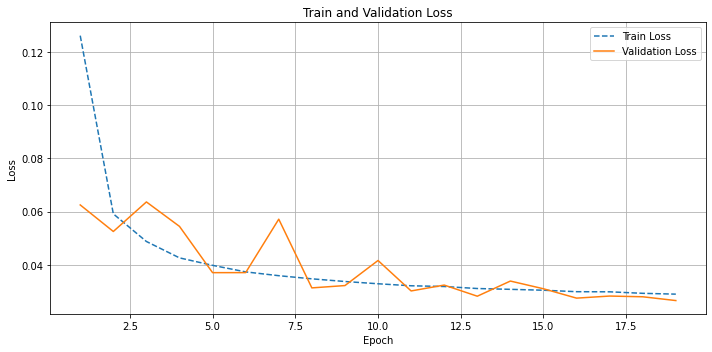


Epoch 20/20


Training: 100%|███████████████████████████████| 137/137 [01:09<00:00,  1.97it/s]


Train Loss: 0.028946
Val Loss: 0.031288 | Mean Jaccard: 0.779004 | Mean Dice: 0.850215 | Mean Recall: 0.804874 | Mean Precision: 0.950275 | Mean ConfIndex: 0.514792


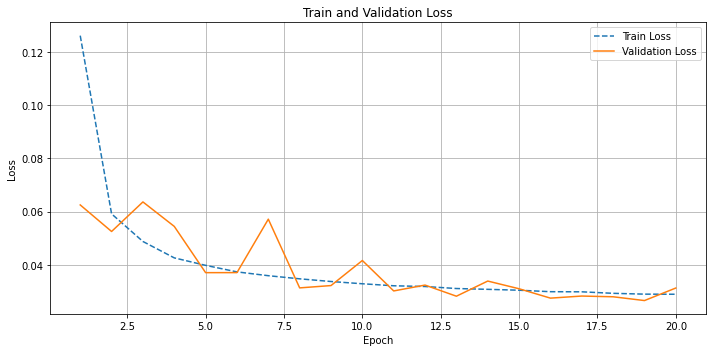

In [33]:
train_model(model.to(device), Train_dataset, Test_dataset, train_transform, val_transform, device, save_path, Dynamically = True, num_epochs=20, lr=1e-4)

# 3) Inference phase

/users/nfs/Etu3/21402333/INRAE_Project/Segmentation_methods/../Segmentation_methods/utils.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.lo

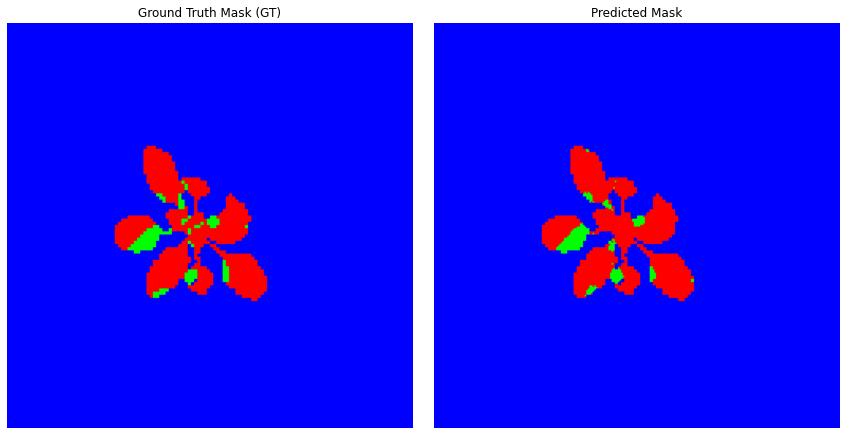

In [5]:
inference(model, test_loader, device, save_path)
